# Synfolding test of paleomagnetic directions

A Synfolding analysis performed at 5% untilt increments, from -50 to 150 untilt.
At each untilting step the complete dataset is evaluated within the *syn_fisher_means* function to separate normal and reversed polarity modes. 

In [1]:
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag
import matplotlib.pyplot as plt # our plotting buddy
from pmagpy import convert_2_magic as convert
import numpy as np # the fabulous NumPy package
import pandas as pd # and of course Pandas
has_basemap, Basemap = pmag.import_basemap()
has_cartopy, Cartopy = pmag.import_cartopy()
from IPython.display import Image
%matplotlib inline 

In [2]:
#define a syn_fisher_means function
def syn_fisher_means(di_block):
    mode_1,mode_2=pmag.separate_directions(di_block) #mode_1,mode_2: 2 arrays of nested dec,inc pairs
    
    mode_1_fpars=ipmag.fisher_mean(di_block=mode_1) # Calculates the Fisher mean and associated parameters of mode 1
    mode_2_fpars=ipmag.fisher_mean(di_block=mode_2)

    # Calculates the Fisher mean of all_to_single_mode directions.
    if mode_2.any():
        to_single_mode_2_dec=mode_2.transpose()[0]+180 # all_to_single mode: all directions shifted to one polarity
        to_single_mode_2_inc= - mode_2.transpose()[1]
        to_single_mode_2 = np.array([to_single_mode_2_dec,to_single_mode_2_inc]).transpose()
        all_to_single = np.concatenate((mode_1,to_single_mode_2))
        all_to_single_fpars =ipmag.fisher_mean(di_block=all_to_single)
    else:
        all_to_single_fpars = mode_1_fpars
    syn_mean = all_to_single_fpars        
    return syn_mean

### Reading input excel file

In [3]:
#reading data from excel spreadsheets and importing into a single dataframe

xls = pd.ExcelFile('gombren/gombren_dir.xlsx')
datafile1 = xls.parse(0)
xls = pd.ExcelFile('borreda/borreda_dir.xlsx')
datafile2 = xls.parse(0)
collecteddata = pd.concat([datafile1,datafile2])


In [4]:
##A look on the Quality of directions

print("Total Number of directions:", len(collecteddata))
print("Directions of Quality 1:", len(collecteddata[collecteddata["Q"]==1]),",", round(100*len(collecteddata[collecteddata["Q"]==1])/len(collecteddata),1),"%")
print("Directions of Quality 2:", len(collecteddata[collecteddata["Q"]==2]),",", round(100*len(collecteddata[collecteddata["Q"]==2])/len(collecteddata),1),"%")
print("Directions of Quality 3:", len(collecteddata[collecteddata["Q"]==3]),",", round(100*len(collecteddata[collecteddata["Q"]==3])/len(collecteddata),1),"%")
print("Directions of Quality 4:", len(collecteddata[collecteddata["Q"]==4]),",", round(100*len(collecteddata[collecteddata["Q"]==4])/len(collecteddata),1),"%")

Total Number of directions: 130
Directions of Quality 1: 12 , 9.2 %
Directions of Quality 2: 56 , 43.1 %
Directions of Quality 3: 23 , 17.7 %
Directions of Quality 4: 39 , 30.0 %


### Select data for foldtest

In [5]:
Qmin = 1
Qmax = 2
foldtestdata = collecteddata[collecteddata['Q'].between(Qmin, Qmax, inclusive=True)]


In [6]:
foldtestdata

,sample,level (m),So_dipdir,So_dip,Dg,Ig,Ds,Is,VGP lat,Int(E-6A/m),error,Q,Temp,comments,angle to mean,Polarity mode
0,GO01,0.0,180,39,359.89,47.10,358.92,86.10,50.012608,507.72,10.99,2,4,200-360,25.729223,N
1,GO02,37.4,180,39,11.80,26.11,24.33,63.53,72.242839,339.08,14.69,1,4,280-360,9.346192,N
2,GO03,71.1,196,42,18.92,13.40,21.13,56.31,72.897432,828.98,3.69,1,4,300-400,9.133353,N
3,GO05,102.9,192,43,357.11,22.79,340.55,62.99,75.721442,830.18,4.44,1,4,280-320,12.028537,N
4,GO07,163.7,187,36,11.94,33.46,18.65,69.16,73.701912,1483.16,7.80,1,4,200-340,10.350500,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,BO45,701.9,339,47,355.65,60.00,347.49,13.91,53.110495,3415.63,2.78,2,4,300-380,NaN,NaN
70,BO46,709.5,339,47,355.54,-47.68,96.71,-77.50,-40.520064,810.93,9.34,2,4,* 200-300,NaN,NaN
72,BO47,734.2,342,43,13.76,-51.91,97.26,-68.96,-36.153258,1823.86,5.00,2,4,200-320,NaN,NaN
75,BO49,734.5,342,43,239.49,39.94,274.91,35.64,16.650835,843.08,7.65,2,4,200-320,NaN,NaN


### Synfolding calculation of fisher statistics

In [7]:
#calculate syn_Ds syn_I at 5% steps from D I dipdir dip

dip_direction = foldtestdata['So_dipdir'].tolist()
dip = foldtestdata['So_dip'].tolist()
dec = foldtestdata['Dg'].tolist()
inc = foldtestdata['Ig'].tolist()
#data = ipmag.make_diddd_array(dec,inc,dip_direction,dip)
synfolding_df = pd.DataFrame()
n = -50
while n <= 150:
    #calculate partial untilt D I with function
    syn_dip = [element*(n/100) for element in dip]  # list comprehension
    data = ipmag.make_diddd_array(dec,inc,dip_direction,syn_dip)
    Dsyn,Isyn=pmag.dotilt_V(data) # rotate them
    di_block = np.array([Dsyn,Isyn]).transpose()
    syn_mean = syn_fisher_means(di_block)    #calculate fisher mean of partial untilt stage n with function
    df = pd.DataFrame(syn_mean, index =[n]) #save results in a row of dataframe
    synfolding_df = synfolding_df.append(df)
    n = n + 5

synfolding_df = synfolding_df.round(2)
synfolding_df[['dec','inc']] = synfolding_df[['dec','inc']].round(0)    
synfolding_df.index.name = '%unfolding'
synfolding_df

,dec,inc,n,r,k,alpha95,csd
%unfolding,,,,,,,
-50,189.0,19.0,68,48.42,3.42,11.04,43.79
-45,190.0,19.0,68,47.45,3.26,11.42,44.86
-40,190.0,16.0,68,46.54,3.12,11.79,45.85
-35,190.0,16.0,68,45.54,2.98,12.19,46.90
-30,191.0,13.0,68,44.57,2.86,12.59,47.90
-25,191.0,10.0,68,43.41,2.72,13.07,49.08
-20,5.0,24.0,68,41.21,2.50,14.01,51.22
-15,3.0,53.0,68,42.95,2.68,13.26,49.52
-10,359.0,60.0,68,44.91,2.90,12.45,47.55


### Save excel file

In [8]:
outputfile = "synfolding.xlsx"
export_file = ''
print('save and overwrite', "synfolding.xlsx?")
while export_file != "y" and export_file != "n":
    export_file = str(input("(y/n)?:"))
    if export_file == 'y':
        synfolding_df.to_excel(outputfile)
        print("file saved to synfolding.xlsx")
    else:
        pass

save and overwrite synfolding.xlsx?
(y/n)?:y
file saved to synfolding.xlsx


<Figure size 432x288 with 0 Axes>

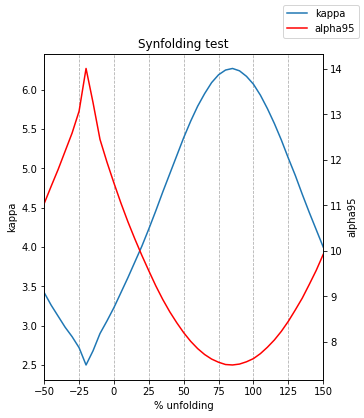

In [9]:
#Plot kappa (left) and a95 (right)
fig = plt.figure()  # an empty figure with no Axes
fig, ax1 = plt.subplots(figsize = (5,6))
ax1.set_xlim(-50, 150)
ax1.set_title("Synfolding test")  # Add a title to the axes.
ax1.plot(synfolding_df['k'], label = 'kappa')
ax1.set_xlabel('% unfolding')  # Add an x-label to the axes.
ax1.set_ylabel('kappa')  # Add an y-label to the axes.
ax1.grid(which='major', axis='x', linestyle='--')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(synfolding_df['alpha95'], label='alpha95', color = 'red')
ax2.set_ylabel('alpha95')  # Add an y-label to the axes.

fig.legend()
fig.savefig("synfolding.png")